# Day 4: Task-Specific Models and Transfer Learning

One of the core themes of cognitive neuroscience is to understand the computational processes that make up an aspect of cognition. In vision, we try to understand the types of stimuli or features a certain brain region is sensitive to to understand the computational structure required to solve visual tasks. One way to investigate the functional architecture of the visual streams is to use convolutional neural networks (CNNs). In the following tutorial you will learn step-by-step how to investigate what kind of features a CNN extracts when solving different tasks of vision and how the receptive field properties of a kernel change. We will do so by using the VGG16 architecture, a slightly outdated but more straightforward neural network architecture, that was also used in the studies presented in the lecture today. You will get the chance to investigate two task-specific networks and see how the features they extract may or may not differ. Lastly, we will see how useful features from one task are for other solving other tasks and what this means for the brain.

What you will learn:


*   Gain a deeper understanding of the visual processing steps in artificial neural networks by optimizing inputs
*   Investigate the computational similarity between different visual tasks
*   Use statistical analyses to link network layers to brain regions


Before we start, make sure to load the following libraries and download the files! You can do so by running the following blocks of code.

Also, make sure to change the runtime so that GPU operations become possible! These will come in handy especially later in the tutorial when we will do some transfer learning. Choosing the correct runtime at the beginning will ultimately save you time as otherwise you will have to redownload the datasets and weights.

As a last note: during the tutorial you will see ellipses (...) pop up in the code. These mean that you need to fill in some code yourself.

In [ ]:
!pip install torch_cka

# These are some basic data science libraries that allow us to investigate our datasets and plot some graphs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# These are all the libraries that will allow us to do Deep Learning
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torch_cka import CKA

# TQDM is a useful library that implements progress bars for for-loops
from tqdm.notebook import tqdm

# These are some file-management libraries we will need in the beginning
import os
import shutil
import zipfile

# Setting the correct device to use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Now we will get all the files we need. Click the following to access all the files required for this tutorial:

[Click me](https://www.google.com/url?q=https%3A%2F%2Fdrive.google.com%2Fdrive%2Ffolders%2F1yFNw65xd79dxlgnyrdxI5U2BwyjRVh7h%3Fusp%3Dsharing)

Make sure to create a shortcut to your own Google Drive. This will allow us to link Colab to Google Drive so we do not need to download anything. You will then be able to navigate to the shared folder and access the files.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

source_folder = '/content/drive/MyDrive/SummerSchoolTutorials'
destination_folder = '/content/SummerSchoolTutorials'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Copy files from Google Drive to the local directory
for item in os.listdir(source_folder):
    source_path = os.path.join(source_folder, item)
    destination_path = os.path.join(destination_folder, item)
    if os.path.isfile(source_path):
        shutil.copy(source_path, destination_path)

# Unzip the zip files into the local directory
for item in os.listdir(destination_folder):
    if item.endswith('.zip'):
        zip_path = os.path.join(destination_folder, item)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(destination_folder)
        os.remove(zip_path)  # Remove the zip file after extracting

# Remove __MACOSX directories if they exist
for root, dirs, files in os.walk(destination_folder):
    if '__MACOSX' in dirs:
        shutil.rmtree(os.path.join(root, '__MACOSX'))

# List the files in the local directory to confirm
os.listdir(destination_folder)

## Investigating our Model: VGG16 and ImageNet


If you go to the folder icon on the left of the screen you will now see various datasets that have been downloaded from github. Before we start looking at the individual kernels/filters of some trained networks, let us familiarize ourselves with the architecture. One of the easiest way to inspect a neural network architecture in PyTorch is to simply print() the model after it has been initialized. In the following steps, we will use some pretrained weights for one of the most popular datasets of all time, ImageNet-1k. ImageNet-1k, despite being a subset of an even larger dataset, is still a massive dataset of a thousand different categories of objects and over one million images in total. Due to its sheer variety in classes, it is a popular dataset to use as a startpoint for more specific tasks as it forces the model to learn a wide range of features. The pretrained network will help us visualize some general processing tendencies of neural networks.

In [ ]:
# VGG16 is already available in PyTorch. Setting pretrained to True will load weights for Imagenet, a popular dataset for object recognition
model = torchvision.models.vgg16(pretrained = True)

# Printing the model will show you the layers and their amount of filters. This will be useful later when we select kernels to visualize
print(model)

As you can see the network is divided into two major parts, the encoder (here named 'features') and its 13 convolutional layers and the classifier with its 3 fully-connected layers, giving the network its self-descriptive name VGG16 (VGG is the name of the group at the University of Oxford that created this model). The encoder part of VGG16 performs mathematical convolutions over the input image that are sensitive to specific patterns in the input and have a high activation if they are detected or a low output if not resulting in feature or activation maps. The next convolution is then performed on the exactly these activation maps until the last layer of the encoder. At the end of the encoder, the features are then vectorized into a massive one-dimensional vector by flattening out all the two-dimensional feature maps. In the classifier section of VGG16, you can see that the first linear layer (model.classifier[0]) takes 25,088 input values which corresponds the flattened version of the 512 feature maps that you can see above. A little bit of arithmetic will reveal that each of these feature maps has to be 7 x 7 in size in order for the classifier to work with the encoder. This is exactly the size achieved after the last encoder layer.

In the next few minutes we will have a look at some of these feature maps to develop an understanding of how they represent aspects of the input. To do this, you can first select any image you like by uploading a jpg to Google Colab and inserting its pathname into the Image.open() function. The image is then visualized using plt.imshow(). To make this more insightful it would be wise to pick an image that represents some objects and a somewhat complex background. Keep in mind, that this network is trained on objects so it will respond to features that are commonly found in objects.

In [ ]:
# Insert the file_path to an image of your choice
img = Image.open('path/to/your/image.jpg')

plt.imshow(img)

By looking at the axes ticks, you can see the size of the image in pixels. For our VGG16 network to properly work, we might need to resize the image to the input size it expects. For VGG16, the expected input is 224 x 224 pixels over the 3 RGB channels plus one dimension representing the batch size. By using the transform described below we can resize the image to this size. Lastly we unsqueeze the image to add the batch dimension. Now the image can be used with VGG16.

In [ ]:
transform = transforms.Compose([ transforms.Resize((224, 224)), transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
img_t = transform(img)

img_t = torch.unsqueeze(img_t, 0)

Great, now our image is ready to be fed into the model for processing. What we will do now is to visualize how each kernel reacts to our input image. Keep in mind that all the individual feature maps are two-dimensional arrays. This means that we can visualize them using a pseudo-color space of our choice. First, let us isolate the encoder part of the model as we are currently not interested in the classifier.

In [ ]:
encoder = model.features

There are two ways how we can now access the feature maps of a layer of our choice:


1.   Slicing into the architecture to remove all layers above our layer
2.   Installing a hook in the layer of our choice

In this tutorial, we will choose the second option. A hook is special type of function that gets called as soon as the layer the hook is attached to processes the input. We can attach this hook to a layer by using the register_forward_hook(hook) method on our layer. You can select any layer you want here but make sure that the index is valid by inspecting the printed model above.

In [ ]:
layer = encoder[1]

def extract_maps(module, input, output):
  # By using "global" this variable becomes accessible even outside the local space of the function

  global feature_maps
  feature_maps = output

# Now we need to install the hook to link our function to the layer

hook = layer.register_forward_hook(extract_maps)

Whenever we pass an input like our image through this network, the hook will now assign the output of that layer to the variable "feature_maps". Let's pass our input image through the layers and plot the feature maps that are computed there.

In [ ]:
with torch.no_grad():
    _ = encoder(img_t)

 # Now that the hook has done its job we can also remove it from the network

hook.remove()

Before we plot the feature maps, let us inspect the shape of the tensor.

In [ ]:
print(feature_maps.size())

Depending on the layer that you chose you will have a tensor of a different size but the overall structure remains the same:

batch x feature_maps x height x width

Using this knowledge to index into the tensor we can visualize the feature_map of a kernel now using plt.imshow(). Choose a kernel of your choice and visualize the feature map.

I have also added a bit of code that will overlay a higher-resolution version of the activation onto the original image that you chose.

In [ ]:
kernel = 42

feature_maps_s = feature_maps.squeeze(0)

plt.imshow(feature_maps_s[kernel].numpy(), cmap = 'viridis')

plt.show()

feature_maps_n = (feature_maps_s - feature_maps_s.min()) / (feature_maps_s.max() - feature_maps_s.min())

feature_maps_u = feature_maps_n.unsqueeze(0)
feature_maps_r = torch.nn.functional.interpolate(feature_maps_u, size=(224, 224), mode='bilinear', align_corners=False)
feature_maps_s2 = feature_maps_r.squeeze(0)

feature_map_num = feature_maps_s2[kernel].detach().numpy()
feature_map_colored = plt.cm.jet(feature_map_num)[:, :, :3]

input_image_np = img_t.squeeze(0).permute(1, 2, 0).numpy()
input_image_np = (input_image_np - input_image_np.min()) / (input_image_np.max() - input_image_np.min())

overlay = input_image_np * 0.3 + feature_map_colored * 0.7  # Blend the images

plt.imshow(overlay)

**ToDo (1)**:

Visualize feature maps of different layers and compare them. Try to identify what features these layers extract.

You can write your code down here or you can rerun the cells above multiple times.

In [ ]:
# Write your code here

...

...

...

...

Below you can find the entire code combined with only a gap for the layer index and kernel index by clicking "Show code".

In [ ]:
# @title
layer = encoder[...]
kernel = ...

def extract_maps(module, input, output):
  # By using "global" this variable becomes accessible even outside the local space of the function

  global feature_maps
  feature_maps = output

# Now we need to install the hook to link our function to the layer

hook = layer.register_forward_hook(extract_maps)

with torch.no_grad():
    _ = encoder(img_t)

 # Now that the hook has done its job we can also remove it from the network

hook.remove()

feature_maps_s = feature_maps.squeeze(0)

plt.imshow(feature_maps_s[kernel].numpy(), cmap = 'viridis')

plt.show()

feature_maps_n = (feature_maps_s - feature_maps_s.min()) / (feature_maps_s.max() - feature_maps_s.min())

feature_maps_u = feature_maps_n.unsqueeze(0)
feature_maps_r = torch.nn.functional.interpolate(feature_maps_u, size=(224, 224), mode='bilinear', align_corners=False)
feature_maps_s2 = feature_maps_r.squeeze(0)

feature_map_num = feature_maps_s2[kernel].detach().numpy()
feature_map_colored = plt.cm.jet(feature_map_num)[:, :, :3]

input_image_np = img_t.squeeze(0).permute(1, 2, 0).numpy()
input_image_np = (input_image_np - input_image_np.min()) / (input_image_np.max() - input_image_np.min())

overlay = input_image_np * 0.3 + feature_map_colored * 0.7  # Blend the images

plt.imshow(overlay)

**ToThink (1)**:

What property of the neural network allows the deeper neurons to be sensitive to more complex patterns? What is the analogue of that property in the visual system in the brain? You can write your answer below:

*Write your answer here*



### Optimizing inputs to find receptive field properties of kernel

Just before, we have looked at how an image is processed by a neural network. However, especially for deeper layers, it is a bit tedious to see with that method what a kernel actually responds to, as we would need to test it on a large set of images and compare them.

Instead, we will employ a different strategy than before. Rather than trying different inputs for the network to see when and to what a kernel reacts, we can also let the kernel pick its favourite input image.

We can do this by using an optimization algorithm such as Adam or Stochastic Gradient Descent on the input to the model. Instead of tweaking the model weights to minimize the loss, we now tweak the image values to maximize the activation of the kernel.

Let's initialize a random array in the shape of the input required by the model. We can do so by using the torch.randn() function which creates a tensor with random float values from the standard normal distribution in the desired shape. In addition, we will set the attribute requires_grad to True. This will allow the optimization algorithm to tweak the input values.

In [ ]:
# We will start by using an image consisting of only noise

input_image = torch.randn(1, 3, 224, 224, requires_grad=True)

Now we have a random tensor in the shape of an image that can be optimized. The next step is to set up the optimizer itself. Instead of the usual net.parameters() we now specify the input_image as the values considered by the optimizer.

In [ ]:
optimizer = torch.optim.Adam([input_image], lr = 0.1)

Just like we did before we can now use a hook to extract the feature_maps.

In [ ]:
layer = encoder[1]

kernel = 42

# Write a function for the hook like before extracts the activation of a particular kernel in the layer of your chocie

def extract_activation(module, input, output):

    global activation

    activation = output[:, kernel, :, :].clone()

hook = layer.register_forward_hook(extract_activation)


Great! Everything is set up now.

**ToDo (2)**:

Fill in the training loop below according to the description at the start of this section. The code below the loop will visualize the optimized input at the end of the training loop. Run it for one kernel so that you know it works. After you have done that, use the function that you completed to optimize the inputs for a few kernels from different layers more quickly.

In [ ]:
def optimize_input(network, layer_idx, kernel_idx):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  input_image = torch.randn(1, 3, 224, 224, requires_grad=True, device=device)

  network = network.to(device)

  optimizer = torch.optim.Adam([input_image], lr = 0.1)

  layer = network[layer_idx]

  def extract_activation(module, input, output):

      global activation

      activation = output[:, kernel_idx, :, :].clone()

  hook = layer.register_forward_hook(extract_activation)

  iterations = 250

  pbar = tqdm(range(iterations), desc = 'Image Optimization', total = iterations)

  for i in pbar:

    ...

    ...

    loss = ...

    ...

    ...

    pbar.set_postfix({'Loss': loss.item()})


  def rescale(img):
    img = img - img.min()
    img = img / img.max()

    return img

  img = input_image.detach().cpu().numpy()[0]
  img = np.transpose(rescale(img), (1, 2, 0))
  plt.imshow(img)
  plt.show()

  hook.remove()

If you are struggling, you can find the answer below by clicking "Show Code".




In [ ]:
# @title
def optimize_input(network, layer_idx, kernel_idx):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  input_image = torch.randn(1, 3, 224, 224, requires_grad=True, device=device)

  network = network.to(device)

  optimizer = torch.optim.Adam([input_image], lr = 0.1)

  layer = network.features[layer_idx]

  def extract_activation(module, input, output):

      global activation

      activation = output[:, kernel_idx, :, :].clone()

  hook = layer.register_forward_hook(extract_activation)

  iterations = 250

  pbar = tqdm(range(iterations), desc = 'Image Optimization', total = iterations)

  for i in pbar:

    optimizer.zero_grad()

    network(input_image)

    loss = -activation.mean()

    loss.backward()

    optimizer.step()

    pbar.set_postfix({'Loss': loss.item()})

  def rescale(img):
    img = img - img.min()
    img = img / img.max()

    return img

  img = input_image.detach().cpu().numpy()[0]
  img = np.transpose(rescale(img), (1, 2, 0))
  plt.imshow(img)
  plt.show()

  hook.remove()

In [ ]:
layer = ...
kernel = ...

optimize_input(encoder, layer, kernel)

The process you just ran is called gradient ascent which is simply the opposite of gradient descent. Instead of always going into the direction opposite of the gradient value we now follow the gradient in the same direction. Instead of finding a local/global minimum, this process instead finds a local/global maximum of a loss landscape. In this particular instance, it finds a local maximum for the activation of the feature map generated by the kernel of interest.

**ToThink (2)**:

How do the different layers differ in what their kernels seem to prefer? Can you see any similarities to the human visual system?

Write your observations below

*Write your answer here*


## Investigating different task-specific models

Now that you have investigates the model when it is pretrained on object recognition, do the same for another task. A neural network learns to extract features that help classification most, but how do these features differ among other tasks. Is there just a general set of features that help the network deal with all types of visual stimuli or are there some task-specific features. To answer this question, we will look at another network of your choice that represents another type of visual stimuli. By investigating how the required features differ across different tasks, we can also get a deeper understanding of how these tasks set different computational demands

I have prepared two additional pretrained model weights for you to investigate.

1) Face Recognition


*   File: 'face_vgg16_weights.pth'
*   Dataset: 80 types of face identities from the PINS dataset
*   Link: https://www.kaggle.com/datasets/hereisburak/pins-face-recognition


2) Object Classification


*   File: 'object_vgg16_weights.pth'
*   Dataset: 80 types of objects (no birds or faces) from the Caltech256
*   Link: https://data.caltech.edu/records/nyy15-4j048


The first dataset is the so-called PINS dataset from Kaggle, a website where you can do a lot of machine-learning-related challenges. The PINS dataset consists of images of 105 different celebrities and can be used for face recognition.

The second file contains the weights of a model trained on a self-selected subset of the Caltech-256 dataset for object classification. Despite weights for ImageNet being already available, I chose this smaller dataset as it is faster for training when we do some transfer learning later.

If you want, you can also check out the types of images used for pretraining. They should be among the files that you downloaded in the beginning of this tutorial.

In the following section, we will try to compare these networks with each other to see how well face recognition features transfer to object recognition and vice versa. We will begin by identifying how similar the extracted features are and will then do some transfer learning.

To use these models, we can load the weights by using the load_state_dict method on our initial model. Remember that weights are essentially just multi-dimensional tensors. In PyTorch, the weight tensors are stored within dictionaries with the layers as the keys for the weight matrices. Using load_state_dict, the initialized weights get overwritten by the pretrained weights, by matching the pretrained weight matrix keys to the existing ones of the initialized model.


In [ ]:
face_vgg = torchvision.models.vgg16(pretrained = False)

object_vgg = torchvision.models.vgg16(pretrained = False)

face_vgg_weights = torch.load('/content/SummerSchoolTutorials/Weights/face_vgg16_weights.pth', map_location=torch.device('cpu'))

object_vgg_weights = torch.load('/content/SummerSchoolTutorials/Weights/object_vgg16_weights.pth', map_location=torch.device('cpu'))

# Change the number of classes in the classifier

num_classes = 80

num_features = face_vgg.classifier[6].in_features
face_vgg.classifier[6] = nn.Linear(num_features, num_classes)

num_features = object_vgg.classifier[6].in_features
object_vgg.classifier[6] = nn.Linear(num_features, num_classes)

face_vgg.load_state_dict(face_vgg_weights)
object_vgg.load_state_dict(object_vgg_weights)

Now that you have loaded the pretrained weights, we can investigate the similarities across networks. We will first run an overly simplified comparison and then we will do centered kernel analysis, which serves a similar purpose as RSA. This section just serves as an appetizer to the transfer learning we will do later.

**ToDo (3)**:

Take your original image, extract the activation maps of the same layer from two different networks and correlate them. You can vectorize the activation maps using torch.flatten(), which will transform your multi-dimensional tensor into a one-dimensional tensor. Do this for two or three layers of different depths.

In [ ]:
# Fill in the rest of the code. You may copy paste from before

img = Image.open('path/to/your/image.jpg')

layer_idx = ...

transform = transforms.Compose([ transforms.Resize((224, 224)), transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
img_t = transform(img)

img_t = torch.unsqueeze(img_t, 0)

face_layer = face_vgg.features[layer_idx]

...

...

...

face_hook = ...

...

face_hook.remove()

object_layer = object_vgg.features[layer_idx]

...

...

...

object_hook = ...

...

object_hook.remove()

feature_maps_face_flat = torch.flatten(feature_maps_face.detach()).numpy()

feature_maps_object_flat = torch.flatten(feature_maps_object.detach()).numpy()

...

...


If you get stuck or want to check your answer, click "Show code"

In [ ]:
# @title
# Answer for above

img = Image.open('path/to/your/image.jpg')

layer_idx = 29

transform = transforms.Compose([ transforms.Resize((224, 224)), transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
img_t = transform(img)

img_t = torch.unsqueeze(img_t, 0)

face_layer = face_vgg.features[layer_idx]

def extract_features_face(module, input, output):

  global feature_maps_face

  feature_maps_face = output

face_hook = face_layer.register_forward_hook(extract_features_face)

face_vgg(img_t)

face_hook.remove()

object_layer = object_vgg.features[layer_idx]

def extract_features_object(module, input, output):

  global feature_maps_object

  feature_maps_object = output

object_hook = object_layer.register_forward_hook(extract_features_object)

object_vgg(img_t)

object_hook.remove()

feature_maps_face_flat = torch.flatten(feature_maps_face.detach()).numpy()

feature_maps_object_flat = torch.flatten(feature_maps_object.detach()).numpy()

print(np.corrcoef(feature_maps_face_flat, feature_maps_object_flat))

**ToThink (3)**:

The correlation values are pretty low but we can be certain that some of the layers should actually semantically be much more similar to each other, especially earlier layers. Correlating the feature maps of just one image is insufficient as it is unclear how much the image resembles the typical input image to the network, which is especially problematic if you have two networks trained on different datasets.

Instead, we will run the following analysis to provide a more accurate account on network similarity. You will see that there seems to be a slight trend in the network in that earlier layers are more similar while later layers are slightly more dissimilar. What does this tell us about the features that the tasks require and what might this imply for the brain?

IMPORTANT: This analysis can take quite long (20 minutes for batch_size = 16), so you can skip to the results below if you want:

You can write your answer below these two code blocks:

In [ ]:
from torch.utils.data import ConcatDataset

transform = transforms.Compose([ transforms.Resize((224, 224)), transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

dataset1 = datasets.ImageFolder('/content/SummerSchoolTutorials/Datasets/Objects_val', transform=transform)
dataset2 = datasets.ImageFolder('/content/SummerSchoolTutorials/Datasets/Faces_val', transform=transform)

combined_dataset = ConcatDataset([dataset1, dataset2])

torch.manual_seed(42)

dataloader = DataLoader(combined_dataset,
                        batch_size=16,
                        shuffle=False)

cka = CKA(face_vgg, object_vgg,
          model1_name="FaceVGG",
          model2_name="ObjectVGG",
          device='cpu')

cka.compare(dataloader)

results = cka.export()

#This code is provided by

#@software{subramanian2021torch_cka,
#   author={Anand Subramanian},
#    title={torch_cka},
#    url={https://github.com/AntixK/PyTorch-Model-Compare},
#    year={2021}

Now you can visualize the results here!

In [ ]:
cka_values = results['CKA'].numpy()
model1_layers = results['model1_layers']
model2_layers = results['model2_layers']

# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(cka_values, cmap='viridis')

# Add color bar
fig.colorbar(cax)

# Set axis labels
ax.set_xticks(np.arange(len(model2_layers)))
ax.set_yticks(np.arange(len(model1_layers)))
ax.set_xticklabels(model2_layers, rotation=45, ha='left')
ax.set_yticklabels(model1_layers)

plt.title(f"CKA Similarity between {results['model1_name']} and {results['model2_name']}")
plt.xlabel(f"{results['model2_name']} Layers")
plt.ylabel(f"{results['model1_name']} Layers")
plt.show()


*Write your answer here*

### Results of CKA if Issues with Running Code

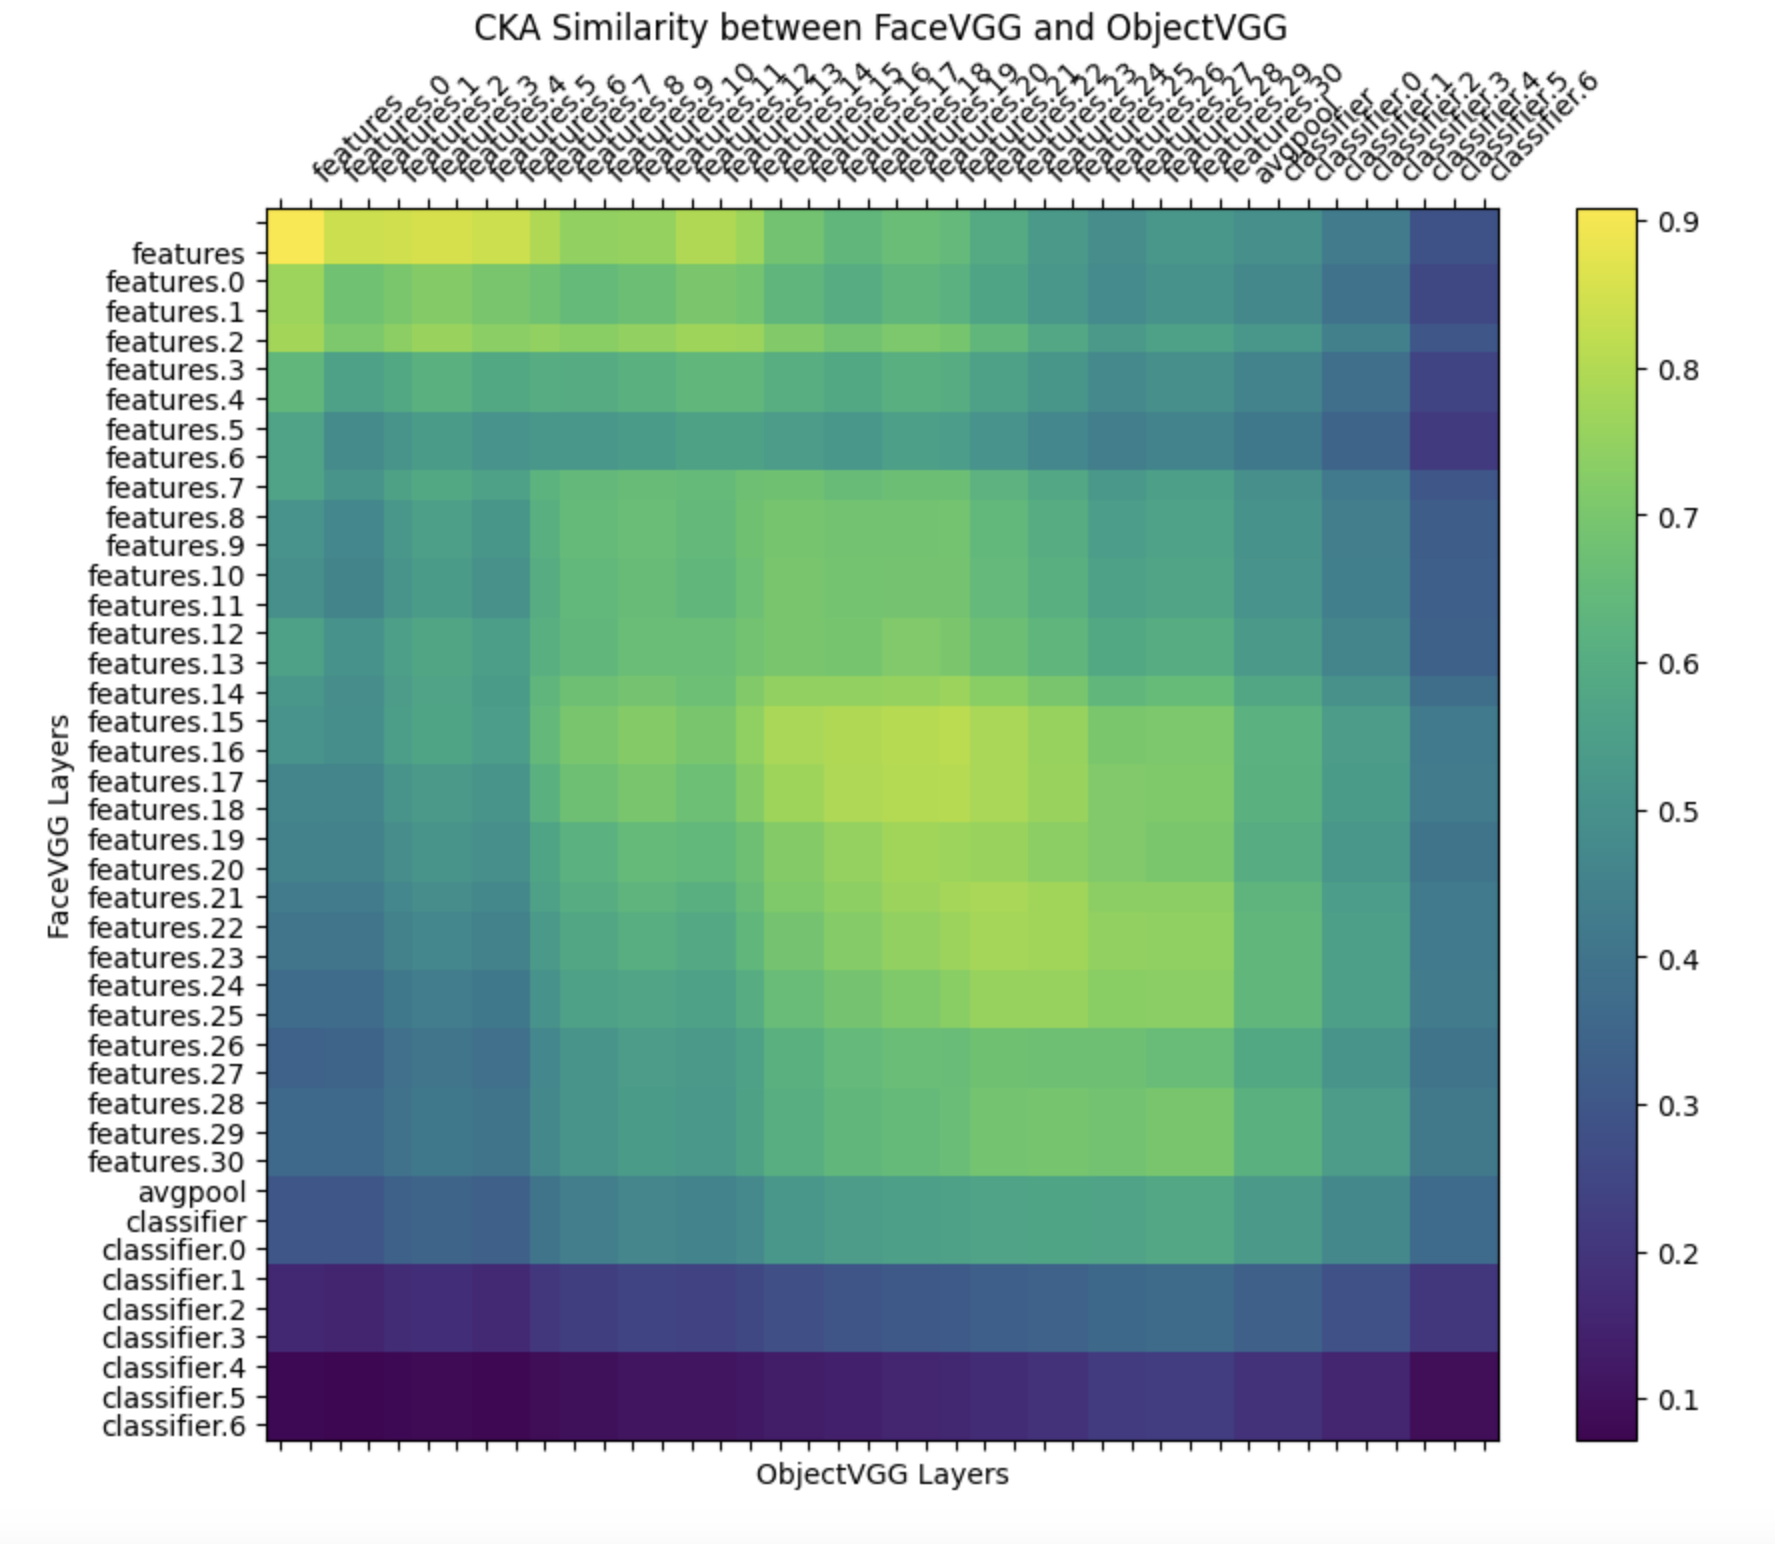

### Intermediate Conclusion

The method you just used is called Centered Kernel Alignment (CKA) and is much more advanced than what we consider you should learn in this tutorial. It works by computing the the similarity between Gram matrices instead of the similarity of dissimilarity matrices like RSA. Both methods can be used when comparing network similarity.
If you are interested in other advanced methods to compare neural networks, you can check out this fun paper, which provides a good survey into all the methods that have been proposed:
https://arxiv.org/abs/2305.06329 Klabunde et al., 2023
You will see that there are numerous methods being proposed for this issue alongside RSA and CKA.

So far, you have learned ways to visualize feature maps and to optimize kernel input, which provided you an opportunity to see the network perform on a single kernel-level. Then, you analyzed how two different networks relate to each other based on feature maps. Let's put this similarity to the test in the next section!


## Transfer Learning: how well can a task-specific network perform other tasks?

### Retraining the classifier

Transfer learning, traditionally, is about fine-tuning models to a specific purpose in order to save computational resources or avoid having to build gigantic datasets yourself. When we do transfer learning we can use pretrained models as a starting point for training our model, such as the ImageNet VGG16 you have used before. These have already been trained for a lot of time and using a lot of data, so by relying on the features that the encoder of those models extracts we can save a lot of computational resources and time. This can be particularly useful if you are working on a niche topic.

We can also use Transfer Learning to investigate the similarities between tasks. The idea is that the feature maps that are extracted to solve one tasks can be applicable to another task, and the extent of this relationship depends on the similarities between the tasks. More similar tasks will allow for more successful transfer learninig than less similar tasks.

For this tutorial, we will use a Transfer Learning method similar to the one that was used in one of the studies described in the lecture earlier today. Instead of freezing only the encoder and training the classifier, we will extract the vectorized features from up the penultimate classifier label. This is the last layer of the network in which the computations are still meaningful for the general task. The final layer is simply the "interpreter" and links the feature vectors to the classes.

Before we freeze the network layers so that they are unaffected by the training, we will shorten the network classifier to exclude the final layer. Later on, we will create a new final layer and it will be that layer that is tweaked in training.
The extent to which a network is frozen in transfer learning depends on what you want to do. If you want to just have a starting point for training a new model, you should give the new model some breathing space by freezing less of the network. However, we are concerned about how well exactly those features that are used for one task transfer to another task. That is why we are freezing almost the entire network.

In [ ]:
face_vgg.classifier = torch.nn.Sequential(
    *list(face_vgg.classifier.children())[:-2]
)

# Print the modified model
print(face_vgg)

As you can see, the classifier no longer has the final classification layer that was responsible for mapping the feature vectors to the class labels. We will now "freeze" the entirety of this network by setting the requires_grad parameter to False in each layer.

In [ ]:
for param in face_vgg.parameters():
    param.requires_grad = False

Great, now that we have access to all the feature representations of the penultimate layer of the network, we can initialize a new ultimate layer with random weights. This layer is the only one that is trained during transfer learning. Because it the trainable part consists of only one layer, the network can only try to match encoding patterns based on the features extracted by the shortened VGG16 to classify the new input images.

In [ ]:
# Add the new classifier layer
new_classifier = torch.nn.Linear(4096, 20, bias=True)

# Replace the last layer with the new classifier
face_vgg.classifier = torch.nn.Sequential(
    *list(face_vgg.classifier.children()),
    new_classifier
)

# Ensure the new classifier layer is trainable
for param in face_vgg.classifier[-1].parameters():
    param.requires_grad = True

# Print the modified model
print(face_vgg)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(face_vgg.classifier[-1].parameters(), lr=0.001, momentum=0.9)


The network is now ready for transfer learning. However, to understand how well the feature space of the model transfers from its specialized task to another task we still need some input data, in particular data from two types of datasets:

1.   A dataset of the same task type but with unseen classes
2.   A dataset of a different task type

These datasets have already been created for you. You can find them in the HoldOut Folder that you downloaded in the beginning.

In [ ]:
transform = transforms.Compose([ transforms.Resize((224, 224)), transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

dataset = datasets.ImageFolder('/content/SummerSchoolTutorials/Hold Out/HoldOutFaces', transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

The first dataset is now ready and we can start doing the actual transfer learning. For this we will write some basic training code and let the model train for only a few epochs. Because our trainable network is so small (only one layer) there really is no need to train for a long period of time.

In [ ]:
num_epochs = 5

face_vgg = face_vgg.to(device)

face_vgg.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    train_pbar = tqdm(enumerate(train_loader), desc=f'Training Epoch {epoch + 1}/{num_epochs}', total=len(train_loader))

    for i, batch in train_pbar:
        input_image, label = batch

        input_image, label = input_image.to(device), label.to(device)

        optimizer.zero_grad()

        output = face_vgg(input_image)
        loss = criterion(output, label)

        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Calculate accuracy
        predicted = torch.argmax(output, dim = 1)

        total += label.size(0)
        correct += (predicted == label).sum().item()

        accuracy = correct / total

        # Update progress bar postfix
        train_pbar.set_postfix({'loss': running_loss / (i + 1), 'accuracy': accuracy, 'correct':correct})


test_pbar = tqdm(enumerate(test_loader), desc=f'Testing', total=len(test_loader))

correct = 0
total = 0

face_vgg.eval()

for i, batch in test_pbar:
      input_image, label = batch

      input_image, label = input_image.to(device), label.to(device)

      output = face_vgg(input_image)

      # Calculate accuracy
      predicted = torch.argmax(output, dim = 1)
      total += label.size(0)
      correct += (predicted == label).sum().item()

      accuracy = correct / total

      # Update progress bar postfix
      test_pbar.set_postfix({'accuracy': accuracy})

**ToDo (4)**:

Repeat the training for the other dataset. Then switch networks and do the entire process again. To help you a bit, I have written some functions that reinitialize a network with the weights of your choice and also a function for the training.

You should run the Object VGG on both Object Hold Out and Face Hold and the Face VGG on Object Hold Out and Face Hold Out.

Lastly, create a bar plot that visualizes the transfer accuracies.

If you ran out of GPU computing units, time, or struggle with the task, you can use a short cut below!

In [ ]:
def set_up_network(weight_path):

  model = torchvision.models.vgg16(pretrained = False)
  weights = torch.load(weight_path, map_location=torch.device('cpu'))

  num_classes = 80
  num_features = model.classifier[6].in_features
  model.classifier[6] = nn.Linear(num_features, num_classes)

  model.load_state_dict(weights)

  model.classifier = torch.nn.Sequential(
    *list(model.classifier.children())[:-2]
  )
  for param in model.parameters():
      param.requires_grad = False

  new_classifier = torch.nn.Linear(4096, 20, bias=True)

  # Replace the last layer with the new classifier
  model.classifier = torch.nn.Sequential(
      *list(model.classifier.children()),
      new_classifier
  )
  # Ensure the new classifier layer is trainable
  for param in model.classifier[-1].parameters():
      param.requires_grad = True

  criterion = nn.CrossEntropyLoss()

  optimizer = optim.SGD(model.classifier[-1].parameters(), lr=0.001, momentum=0.9)

  return model, criterion, optimizer

def train_network(model, criterion, optimizer, dataset_path):

  transform = transforms.Compose([ transforms.Resize((224, 224)), transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

  dataset = datasets.ImageFolder(dataset_path, transform=transform)

  train_size = int(0.8 * len(dataset))
  test_size = len(dataset) - train_size
  train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

  # Data loaders
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

  num_epochs = 5

  model = model.to(device)

  model.train()

  for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    train_pbar = tqdm(enumerate(train_loader), desc=f'Training Epoch {epoch + 1}/{num_epochs}', total=len(train_loader))

    for i, batch in train_pbar:
        input_image, label = batch

        input_image, label = input_image.to(device), label.to(device)

        optimizer.zero_grad()

        output = model(input_image)
        loss = criterion(output, label)

        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Calculate accuracy
        predicted = torch.argmax(output, dim = 1)

        total += label.size(0)
        correct += (predicted == label).sum().item()

        accuracy = correct / total

        # Update progress bar postfix
        train_pbar.set_postfix({'loss': running_loss / (i + 1), 'accuracy': accuracy, 'correct':correct})

  test_pbar = tqdm(enumerate(test_loader), desc=f'Testing', total=len(test_loader))

  correct = 0
  total = 0

  model.eval()

  for i, batch in test_pbar:
    input_image, label = batch

    input_image, label = input_image.to(device), label.to(device)

    output = model(input_image)

    # Calculate accuracy
    predicted = torch.argmax(output, dim = 1)
    total += label.size(0)
    correct += (predicted == label).sum().item()

    accuracy = correct / total

    # Update progress bar postfix
    test_pbar.set_postfix({'accuracy': accuracy})

    return accuracy


Now you can repeat the training code below:

In [ ]:
# Write your code here

face_net, criterion, optimizer = set_up_network('/content/SummerSchoolTutorials/Weights/face_vgg16_weights.pth')

face_net_to_face = train_network(face_net, criterion, optimizer, '/content/SummerSchoolTutorials/Hold Out/HoldOutFaces')

print(face_net_to_face)

...

...

...

...

...


If you struggle, you can load this cell to see the answers:

In [ ]:
# @title
#face_net, criterion, optimizer = set_up_network('/content/SummerSchoolTutorials/Weights/face_vgg16_weights.pth')

#face_net_to_face = train_network(face_net, criterion, optimizer, '/content/SummerSchoolTutorials/Hold Out/HoldOutFaces')

#print(face_net_to_face)

#face_net, criterion, optimizer = set_up_network('/content/SummerSchoolTutorials/Weights/face_vgg16_weights.pth')

#face_net_to_object = train_network(face_net, criterion, optimizer, '/content/SummerSchoolTutorials/Hold Out/HoldOutObjects')

#print(face_net_to_object)

#object_net, criterion, optimizer = set_up_network('/content/SummerSchoolTutorials/Weights/object_vgg16_weights.pth')

#object_net_to_face = train_network(object_net, criterion, optimizer, '/content/SummerSchoolTutorials/Hold Out/HoldOutFaces')

#print(object_net_to_face)

#object_net, criterion, optimizer = set_up_network('/content/SummerSchoolTutorials/Weights/object_vgg16_weights.pth')

#object_net_to_object = train_network(object_net, criterion, optimizer, '/content/SummerSchoolTutorials/Hold Out/HoldOutObjects')

#print(object_net_to_object)


# Accuracy values
#accuracy_values = {
#    'Face to Face': face_net_to_face,
#    'Face to Object': face_net_to_object,
#    'Object to Face': object_net_to_face ,
#    'Object to Object': object_net_to_object
#}

# Accuracy values
accuracy_values = {
    'Face to Face': 0.7614,
    'Face to Object': 0.4548,
    'Object to Face': 0.3647,
    'Object to Object': 0.5892
}

# Create a bar plot
fig, ax = plt.subplots()

# Plot data
ax.bar(accuracy_values.keys(), accuracy_values.values())

# Add title and labels
ax.set_title('Transfer Learning Results')
ax.set_xlabel('Transfers')
ax.set_ylabel('Accuracy')

# Show plot
plt.show()

**ToThink (4)**:

What do the values suggest and what does this tell you about the human visual system?

*Write your answer here*

## Concluding Remarks

Congratulations for finishing this tutorial. I hope you learned a bit more about the ways to investigate a neural network. Transfer learning is a powerful tool to understand task demands and I hope that you may be able to use these concepts in your own studies.

Here is a quick summary of what you have learned:



1.   Visualizing feature maps and relating them to features in an input image
2.   Optimizing inputs to a neural network as a way to understand receptive field properties
3.   Comparing learned features of different networks
4.   Assessing task similarity through Transfer Learning








